**Author**: J W Debelius<br/>
**Date**: 27 August 2015<br/>
**virtualenv**: power play

# 1. Introduction

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import statsmodels.api as sms
import statsmodels.formula.api as smf

import absloute_power.traditional as trad
import absloute_power.utils as ap

from scipy.stats import norm as Z

import americangut.power_plots as pp

import pandas as pd

from skbio.stats.power import subsample_power

from absloute_power.traditional import calc_ttest_ind

In [2]:
from matplotlib import rcParams



# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

% matplotlib inline

We'll examine five common, simple statistical models where the power equation has been defined and employed. The emperical power implementations are based on the version described in [ref].

We will examine statistical power for three tests dealing with normal distributions:

* Case I t test
* Case II (independent) t test
* One way Analysis of Variance (ANOVA)
* Pearson's R
* Chi-Square

We will perform 100 simulations of statistical power, comparing the power between 5 and 50 counts, with 5 observation intervals between. We'll set the critical value at 0.05.

In [3]:
num_rounds = 100
counts = np.arange(5, 55, 5)
alpha = 0.05
distributions = {}

We'll also set a random seed, so that the results we get out are consistent.

# 2. Case I Test

A case I t-test checks if an observation is drawn from a sample. We are testing the alternatively hypotheses,

$\begin{matrix}
\textbf{H}_{0} & x = \bar{x} \\
\textbf{H}_{1} & x \neq \bar{x}\\
\end{matrix} \tag{2.1}$

where $\bar{x}$ is the mean of the population, $x$ is the value being compared to the sample, $s$ is the standard devation of the sample, and there are $n$ observations in the sample.

## 2.1 Test Statistic

The test statistic for the case I t test is given as
$t = \frac{(\bar{x} - x)\sqrt{n}}{s} \tag{2.2}$
The probability distribution follows a T distribution with $n-1$ degrees of freedom, where $n$ is the number of observations in the sample.


For the emperical test, we will use the `scipy.stats.ttest_1samp` function, which returns a p value.

In [4]:
def emp_ttest_ind(sample1, sample2):
    return scipy.stats.ttest_ind(sample1, sample2)[1]

## 2.2 Nonparametric Test

In [5]:
def emp_ttest_ind_nonpar(sample1, sample2):
    return scipy.stats.mannwhitneyu(sample1, sample2)[1]

## 2.3 Effect Size

The effect size for a one-sample t test is Cohen's d, given by equation (2.3).
$\begin{align*}
d = \frac{\bar{x} - x_{0}}{s}
\end{align*}\tag{2.3}$
For a two-tailed test, we can treat this as an absloute magnitude, and then test $t > (1 - \alpha/2)$.

In [6]:
def cohen_ttest_ind(sample1, sample2):
    x1, s1, n1 = sample1.mean(), sample1.std(), len(sample1)
    x2, s2, n2 = sample2.mean(), sample2.std(), len(sample2)
    
    spool = np.sqrt(((n1-1) * np.square(s1) + (n2 - 1) * np.square(s2)) / (n1 + n2 - 2))
    return np.absolute(x1 - x2) / spool

## 2.5 Simulation Parameters

We'll test the set of hypotheses,

$\begin{matrix}
\textbf{H}_{0} & 0 = \bar{x} \\
\textbf{H}_{1} & 0 \neq \bar{x}\\
\end{matrix} \tag{2.5}$

where $\bar{x}$ is the mean of a sample drawn from a population.

We'll test the means between 2 and 10 with standard deviations between 5 and 15, and sample sizes between 60 and 100 observations.

In [7]:
def nonparametric_simulate(mu_lim, sigma_lim, count_lims, bench_lims, diff_lim):
    # Gets the distribution parameters
    mu = np.random.uniform(*mu_lim, size=2)
    offset = np.random.uniform(*diff_lim)
    sigma = np.random.uniform(*sigma_lim, size=2)
    n = np.random.randint(*count_lims)
    m = np.random.randint(*bench_lims)
    
    #     Draws a sample that fits the parameters
    sample1 = np.hstack((np.random.gamma(mu[0], sigma[0], n - m), 
                         np.random.gamma(mu[1], sigma[1], m)))
    sample2 = np.hstack((np.random.gamma(mu[0], sigma[0], n - m), 
                         np.random.gamma(mu[1], sigma[1], m))) + offset

    return [mu, sigma, offset, n, m], [sample1, sample2]

In [8]:
distributions['nonparametric'] = {'emp_test_fun': emp_ttest_ind_nonpar,
                                  'trad_test_fun': calc_ttest_ind,
                                  'sim_function': nonparametric_simulate,
                                  'sim_parameters': [[1, 8.], [2.5, 5.], [125., 126.]],
                                  'other_sim_parameters': {'bench_lims': [25, 75], 'diff_lim': [1.5, 6.5]},
                                  'test_parameters': {},
                                  'emp_parameters': {},
                                  'effect_size': cohen_ttest_ind,
                                   }

In [9]:
def ttest_ind_simulate(mu_lim, sigma_lim, counts_lims):
    """..."""
    # Gets the distribution paramters
    mu1, mu2 = np.random.randint(*mu_lim, size=2)
    sigma1, sigma2 = np.random.randint(*sigma_lim, size=2)
    n = np.random.randint(*counts_lims)
    
    # Returns a pair of distributions
    samples =  [mu1 + np.random.randn(n) * sigma1, mu2 + np.random.randn(n) * sigma2]
    return [mu1, mu2, sigma1, sigma2, n], samples

In [10]:
distributions['ttest_ind'] = {'emp_parameters': {},
                              'emp_test_fun': emp_ttest_ind,
                              'other_sim_parameters': {},
                              'sim_function': ttest_ind_simulate,
                              'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                              'test_parameters': {},
                              'trad_test_fun': trad.calc_ttest_ind,     
                              'effect_size': cohen_ttest_ind
                              }

# 6. Building Simulations

We will now build the simulations and look at the results.

In [11]:
%%time

for k, params in distributions.iteritems():
    print k
    params['mus'] = []
    params['sigmas'] = []
    params['offset'] = []
    params['size'] = []
    params['sample'] = []
    params['sub_sample'] = []
    params['all_effs'] = []
    params['sub_effs'] = []
    params['all_test'] = []
    params['sub_test'] = []
    params['all_empr'] = []
    params['sub_empr'] = []
    params['all_extp'] = []
    params['sub_extp'] = []
    
    for i in xrange(100):
         # Calculates the samples
        [mu, sigma, offset, n, m], samples = params['sim_function'](*params['sim_parameters'], **params['other_sim_parameters'])
        params['mus'].append(mu)
        params['sigmas'].append(sigma)
        params['offset'].append(offset)
        params['size'].append([n - m, m])
        params['sample'].append(samples)
        
        sub_sample = [np.random.choice(s, 25, replace=False) for s in samples]
        params['subsample'] = sub_sample
       
        # Calculates the traditional power
        test_power_all = params['trad_test_fun'](*samples, counts=counts, **params['test_parameters'])
        test_power_sub = params['trad_test_fun'](*sub_sample, counts=counts, **params['test_parameters'])
        params['all_test'].append(test_power_all)
        params['sub_test'].append(test_power_sub)
        
        # Calculates Cohen's effect
        if 'effect_size' in params:
            cohen_eff_all = params['effect_size'](*samples)
            cohen_eff_sub = params['effect_size'](*sub_sample)
        f_ = lambda x: params['emp_test_fun'](*x, **params['test_parameters'])
        
        # Calculates the power for the test
        a_e_pwr, a_e_cnts = subsample_power(f_, samples, min_counts=5, max_counts=55, 
                                            counts_interval=5, num_runs=5, num_iter=1000)
        s_e_pwr, s_e_cnts = subsample_power(f_, sub_sample, min_counts=5, max_counts=25, 
                                            counts_interval=5, num_runs=5, num_iter=1000)

        # Calculates the effect sizes 
        all_emp = ap.z_effect(a_e_cnts, a_e_pwr)
        sub_emp = ap.z_effect(s_e_cnts, s_e_pwr)
        
        # Calculates the power from the effect 
        all_e_power = ap.z_power(counts, all_emp.mean())
        sub_e_power = ap.z_power(counts, sub_emp.mean())
        
        # Updates the dictionary
        params['all_empr'].append(a_e_pwr)
        params['sub_empr'].append(s_e_pwr)
        params['all_extp'].append(all_e_power)
        params['sub_extp'].append(sub_e_power)

        # Updates the information
        params['all_effs'].append([cohen_eff_all, all_emp])
        params['sub_effs'].append([cohen_eff_sub, sub_emp])
        
    distributions[k] = params
    print k

ttest_ind
ttest_ind
nonparametric
nonparametric
CPU times: user 2h 23min 46s, sys: 27.9 s, total: 2h 24min 14s
Wall time: 2h 40min 24s


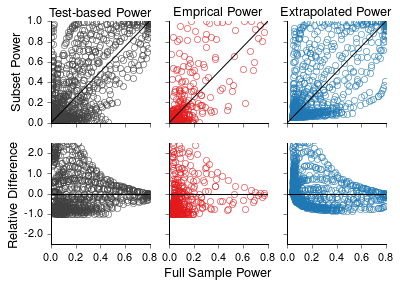

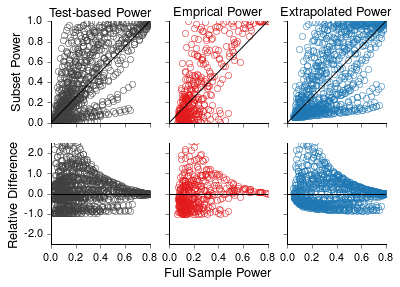

In [12]:
for test in distributions.iterkeys():
    all_test = np.vstack(distributions[test]['all_test'])
    sub_test = np.vstack(distributions[test]['sub_test'])
    all_empm = np.vstack([m.mean(0) for m in distributions[test]['all_empr']])
    all_emps = (np.vstack([m.std(0) for m in distributions[test]['all_empr']]) * 
                np.sqrt(10) / scipy.stats.t.ppf(0.975, 9))
    sub_empm = np.vstack([m.mean(0) for m in distributions[test]['sub_empr']])
    sub_emps = (np.vstack([m.std(0) for m in distributions[test]['sub_empr']]) * 
                np.sqrt(4) / scipy.stats.t.ppf(0.975, 3))
    all_extp = np.vstack(distributions[test]['all_extp'])
    sub_extp = np.vstack(distributions[test]['sub_extp'])


    fig1 = plt.figure()
    ax1 = fig1.add_subplot(2, 3, 1)
    ax1.plot(all_test, sub_test, 'o', mfc='none', mec=[0.25, 0.25, 0.25])
    ax1.plot([0, 1], [0, 1], 'k-')
    ax1.set_title('Test-based Power', size=13)
    ax1.set_ylabel('Subset Power', size=13)

    ax4 = fig1.add_subplot(2, 3, 4)
    ax4.plot(all_test, (sub_test - all_test) / all_test, 'o', mfc='none', mec=[0.25, 0.25, 0.25])
    ax4.plot([0, 1], [0, 0], 'k-')
    ax4.set_ylabel('Relative Difference', size=13)

    ax2 = fig1.add_subplot(2, 3, 2)
    ax2.plot(all_empm[:, :4], sub_empm, 'o', mfc='none', mec='#e31a1c')
    ax2.plot([0, 1], [0, 1], 'k-')
    ax2.set_title('Emprical Power', size=13)

    ax5 = fig1.add_subplot(2, 3, 5)
    ax5.plot(all_empm[:, :4], (sub_empm - all_empm[:, :4]) / all_empm[:, :4], 'o', mfc='none', mec='#e31a1c')
    ax5.plot([0, 1], [0, 0], 'k-')
    ax5.set_xlabel('Full Sample Power', size=13)

    ax3 = fig1.add_subplot(2, 3, 3)
    ax3.plot(all_extp, sub_extp, 'o', mfc='none', mec='#1f78b4')
    ax3.plot([0, 1], [0, 1], 'k-')
    ax3.set_title('Extrapolated Power', size=13)

    ax6 = fig1.add_subplot(2, 3, 6)
    ax6.plot(all_extp, (sub_extp - all_extp) / all_extp,
             'o', mfc='none', mec='#1f78b4')
    ax6.plot([0, 1], [0, 0], 'k-')

    ax1.set_ylim([0, 1])
    ax2.set_ylim([0, 1])
    ax3.set_ylim([0, 1])
    ax4.set_ylim([-2.5, 2.5])
    ax5.set_ylim([-2.5, 2.5])
    ax6.set_ylim([-2.5, 2.5])

    for i, ax in enumerate(fig1.axes):
        if i in {0, 1}:
            ax.set_yticklabels(ax.get_yticks(), size=11)
        else:
            ax.set_yticklabels('')
        if i in {1, 3, 5}:
            ax.set_xticklabels(ax.get_xticks(), size=11)
        else:
            ax.set_xticklabels('')
        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.get_xaxis().set_tick_params(direction='out')
        ax.get_yaxis().set_tick_params(direction='out')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    fig1.savefig('/Users/jwdebelius/Desktop/%s_subcompare_power.pdf' % test)

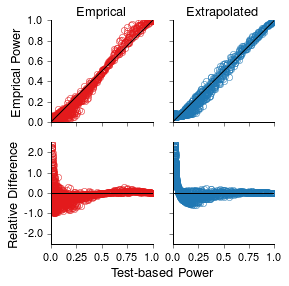

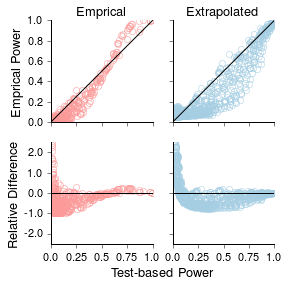

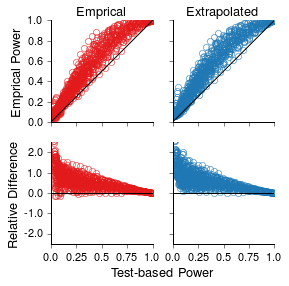

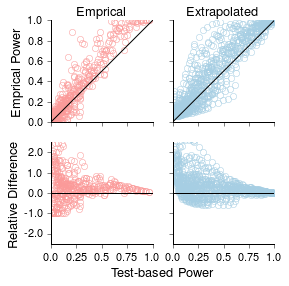

In [12]:
for test in distributions.keys():
    all_test = np.vstack(distributions[test]['all_test'])
    sub_test = np.vstack(distributions[test]['sub_test'])
    all_empm = np.vstack([m.mean(0) for m in distributions[test]['all_empr']])
    all_emps = (np.vstack([m.std(0) for m in distributions[test]['all_empr']]) * 
                np.sqrt(10) / scipy.stats.t.ppf(0.975, 9))
    sub_empm = np.vstack([m.mean(0) for m in distributions[test]['sub_empr']])
    sub_emps = (np.vstack([m.std(0) for m in distributions[test]['sub_empr']]) * 
                np.sqrt(4) / scipy.stats.t.ppf(0.975, 3))
    all_extp = np.vstack(distributions[test]['all_extp'])
    sub_extp = np.vstack(distributions[test]['sub_extp'])

    fig2 = plt.figure()
    fig3 = plt.figure()
    
    ax21 = fig2.add_subplot(2, 2, 1)
    ax31 = fig3.add_subplot(2, 2, 1)
    ax21.plot(all_test, all_empm, 'o', mfc='none', mec='#e31a1c')
    ax31.plot(sub_test[:, :4], sub_empm, 'o', mfc='none', mec='#fb9a99')
    ax21.plot([0, 1], [0, 1], 'k-')
    ax31.plot([0, 1], [0, 1], 'k-')
    ax21.set_title('Emprical', size=13)
    ax31.set_title('Emprical', size=13)
    ax21.set_ylabel('Emprical Power', size=13)
    ax31.set_ylabel('Emprical Power', size=13)
    
    ax22 = fig2.add_subplot(2, 2, 2)
    ax32 = fig3.add_subplot(2, 2, 2)
    ax22.plot(all_test, all_extp, 'o', mfc='none', mec='#1f78b4')
    ax32.plot(sub_test, sub_extp, 'o', mfc='none', mec='#a6cee3')
    ax22.plot([0, 1], [0, 1], 'k-')
    ax32.plot([0, 1], [0, 1], 'k-')
    ax22.set_title('Extrapolated', size=13)
    ax32.set_title('Extrapolated', size=13)
   
    
    ax23 = fig2.add_subplot(2, 2, 3)
    ax33 = fig3.add_subplot(2, 2, 3)
    ax23.plot(all_test, (all_empm - all_test) / all_test, 'o', mfc='none', mec='#e31a1c')
    ax33.plot(sub_test[:, :4], (sub_empm - sub_test[:, :4]) / sub_test[:, :4], 'o', mfc='none', mec='#fb9a99')
    ax23.plot([0, 1], [0, 0], 'k-')
    ax33.plot([0, 1], [0, 0], 'k-')
    ax23.set_ylabel('Relative Difference', size=13)
    l = ax23.set_xlabel('Test-based Power', size=13)
    l.set_position((1.1, 0.5))
    l = ax33.set_xlabel('Test-based Power', size=13)
    l.set_position((1.1, 0.5))
    ax33.set_ylabel('Relative Difference', size=13)
    
    
    ax24 = fig2.add_subplot(2, 2, 4)
    ax34 = fig3.add_subplot(2, 2, 4)
    ax24.plot(all_test, (all_extp - all_test) / all_test, 'o', mfc='none', mec='#1f78b4')
    ax34.plot(sub_test, (sub_extp - sub_test) / sub_test, 'o', mfc='none', mec='#a6cee3')
    ax24.plot([0, 1], [0, 0], 'k-')
    ax34.plot([0, 1], [0, 0], 'k-')

    ax21.set_ylim([0, 1])
    ax22.set_ylim([0, 1])
    ax23.set_ylim([-2.5, 2.5])
    ax24.set_ylim([-2.5, 2.5])
    ax31.set_ylim([0, 1])
    ax32.set_ylim([0, 1])
    ax33.set_ylim([-2.5, 2.5])
    ax34.set_ylim([-2.5, 2.5])

    for i, ax in enumerate(fig2.axes):
        if i in {0, 2}:
            ax.set_yticklabels(ax.get_yticks(), size=11)
        else:
            ax.set_yticklabels('')
        if i in {2, 3}:
            ax.set_xticklabels(ax.get_xticks(), size=11)
        else:
            ax.set_xticklabels('')
        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.get_xaxis().set_tick_params(direction='out')
        ax.get_yaxis().set_tick_params(direction='out')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    ax23.set_xticklabels(np.arange(0, 1.1, 0.25))
    ax24.set_xticklabels(np.arange(0, 1.1, 0.25))
        
    for i, ax in enumerate(fig3.axes):
        if i in {0, 2}:
            ax.set_yticklabels(ax.get_yticks(), size=11)
        else:
            ax.set_yticklabels('')
        if i in {2, 3}:
            ax.set_xticklabels(ax.get_xticks(), size=11)
        else:
            ax.set_xticklabels('')
        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.get_xaxis().set_tick_params(direction='out')
        ax.get_yaxis().set_tick_params(direction='out')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    ax33.set_xticklabels(np.arange(0, 1.1, 0.25))
    ax34.set_xticklabels(np.arange(0, 1.1, 0.25))
        
    fig2.set_size_inches((4, 4))
    fig3.set_size_inches((4, 4))
    
    fig2.savefig('/Users/jwdebelius/Desktop/%s_all_power_compare.pdf' % test)
    fig3.savefig('/Users/jwdebelius/Desktop/%s_sub_power_compare.pdf' % test)

In [30]:
from scipy.stats import t as t

In [27]:
for n, m in zip(*(sub_w, all_w)):
    print n, m

[ 0.78265419  0.79992175  0.87732013  1.01970967  0.82290452  0.79536744
  0.87631123  1.02868765  0.7888069   0.79764562  0.89570231  1.043779
  0.78676076  0.76322227  0.88035428  1.03800788  0.81101292  0.79194621
  0.87128491  1.03991606] [ 0.99930347  1.04282164  1.06844323  1.07726026  1.10396275  1.08086593
  1.10248695  1.0818378   1.06467486  1.07280243  1.06220288  1.06844323
  1.05372398  1.08222968  1.09743097  1.15653326  1.01794517  1.04282164
  1.05552744  1.10110515  1.13524944  1.08884879  1.20722782  1.05798255
  1.03802614  1.05552744  1.09611681  1.0863303   1.1405232   1.15653326
  1.0818378   1.05467594  1.03324915  1.07880233  1.12518808  1.09054587
  1.09743097  1.04436196]
[ 1.30310993  1.33621042  1.5180132   1.3238613   1.32867084  1.5651398
  1.30470348  1.36369424  1.57947926  1.29037518  1.34777132  1.5651398
  1.32066343  1.38451077  1.59528925] [ 0.89696578  0.89558528  0.91243276  0.90447148  0.90737322  0.90534784
  0.91127668  0.9504031   0.9312333   

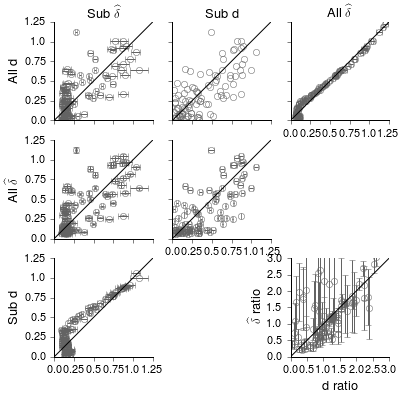

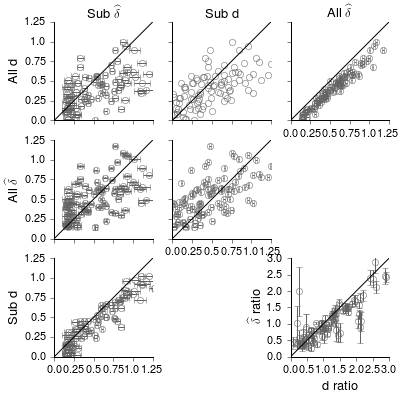

In [40]:
for test in distributions.keys():
    all_d, all_w = zip(*distributions[test]['all_effs'])
    sub_d, sub_w = zip(*distributions[test]['sub_effs'])

    fig4 = plt.figure()

    ax1 = fig4.add_subplot(3, 3, 1)
    ax2 = fig4.add_subplot(3, 3, 2)
    ax3 = fig4.add_subplot(3, 3, 3)
    ax4 = fig4.add_subplot(3, 3, 4)
    ax5 = fig4.add_subplot(3, 3, 5)
    ax6 = fig4.add_subplot(3, 3, 7)
    ax7 = fig4.add_subplot(3, 3, 9)

    ax1.errorbar(y=all_d, 
                 x=[m.mean() for m in sub_w],
                 xerr=[m.std() / np.sqrt(len(m)) * scipy.stats.t.ppf(0.975, len(m) - 1) for m in sub_w],
                  marker='o', mfc='none', mec='#636363', color='#636363', linestyle='none') 
    ax2.errorbar(y=all_d, 
                 x=sub_d, 
                 marker='o', mfc='none', mec='#636363', color='#636363', linestyle='none') 
    ax3.errorbar(y=all_d, 
                 x=[m.mean() for m in all_w], 
                 xerr=[m.std() / np.sqrt(len(m)) * scipy.stats.t.ppf(0.975, len(m) - 1)
                      for m in all_w],
                 marker='o', mfc='none', mec='#636363', color='#636363', linestyle='none')     

    ax4.errorbar(y=[m.mean() for m in all_w], 
                 x=[m.mean() for m in sub_w],
                 yerr=[m.std() / np.sqrt(len(m)) * scipy.stats.t.ppf(0.975, len(m) - 1)
                      for m in all_w],
                 xerr=[m.std() / np.sqrt(len(m)) * scipy.stats.t.ppf(0.975, len(m) - 1)
                        for m in sub_w],
                 marker='o', mfc='none', mec='#636363', color='#636363', linestyle='none') 
    ax5.errorbar(y=[m.mean() for m in all_w], 
                 x=sub_d,
                 xerr=[m.std() / np.sqrt(len(m)) * scipy.stats.t.ppf(0.975, len(m) - 1)
                      for m in all_w],
                 marker='o', mfc='none', mec='#636363', color='#636363', linestyle='none') 
    ax6.errorbar(y=sub_d, 
                 x=[m.mean() for m in sub_w],
                 xerr=[m.std() / np.sqrt(len(m)) * scipy.stats.t.ppf(0.975, len(m) - 1)
                        for m in sub_w],
                 marker='o', mfc='none', mec='#636363', color='#636363', linestyle='none') 
    
    ax7.errorbar(y=np.array([m.mean() for m in sub_w]) / np.array([m.mean() for m in all_w]), 
                 x=np.array(sub_d) / np.array(all_d),
                 yerr=np.array([(n.std() / np.sqrt(len(n)) * t.ppf(0.975, len(n)-1))/ m.mean() +
                                n.mean() * (m.std() / np.sqrt(len(m)) * t.ppf(0.975, len(m) - 1)) / np.square(m.mean())
                                for n, m in zip(*(sub_w, all_w))]),
                 marker='o', mfc='none', mec='#636363', color='#636363', linestyle='none')

    for i, ax in enumerate(fig4.axes[:-1]):
        ax.plot([0, 2], [0, 2], 'k-')
        ax.set_xticks(np.arange(0, 1.35, 0.25))
        ax.set_yticks(np.arange(0, 1.35, 0.25))
        ax.set_xlim([0, 1.25])
        ax.set_ylim([0, 1.25])
        if i in {0, 3, 5}:
            ax.set_yticklabels(ax.get_yticks(), size=11)
        else:
            ax.set_yticklabels('')
        if i in {2, 4, 5}:
            ax.set_xticklabels(ax.get_xticks(), size=11)
        else:
            ax.set_xticklabels('')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.get_xaxis().set_tick_params(direction='out')
        ax.get_yaxis().set_tick_params(direction='out')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    ax7.plot([0, 3.1], [0, 3.1], 'k-')
    ax7.set_xlim([0, 3])
    ax7.set_ylim([0, 3])
    ax7.set_xticks(np.arange(0, 3.1, 0.5))
    ax7.set_yticks(np.arange(0, 3.1, 0.5))
    ax7.set_yticklabels(ax7.get_yticks(), size=11)
    ax7.set_xticklabels(ax7.get_xticks(), size=11)
    ax7.set_ylabel('$\widehat{\delta}$ ratio', size=13)
    ax7.set_xlabel('d ratio', size=13)
    ax7.yaxis.set_ticks_position('left')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.get_xaxis().set_tick_params(direction='out')
    ax7.get_yaxis().set_tick_params(direction='out')
    ax7.spines['right'].set_visible(False)
    ax7.spines['top'].set_visible(False)
    

    ax1.set_ylabel('All d', size=13)
    ax4.set_ylabel('All $\mathsf{\widehat{\delta}}$', size=13)
    ax6.set_ylabel('Sub d', size=13)

    ax1.set_title('Sub $\widehat{\delta}$', size=13)
    ax2.set_title('Sub d', size=13)
    ax3.set_title('All $\widehat{\delta}$', size=13)

    fig4.set_size_inches((6, 6))
    fig4.savefig('/Users/jwdebelius/Desktop/%s_effects.pdf' % test)

In [65]:
1/float(np.sum(check)) * np.sum([n * dm / m + m * dn / n for dm, dn, m, n in zip(*(all_s[check], sub_s[check], all_w[check], sub_w[check]))])

0.064721858382524658

In [87]:
for test in distributions.keys():
    all_d, all_w = zip(*distributions[test]['all_effs'])
    sub_d, sub_w = zip(*distributions[test]['sub_effs'])
    all_d = np.array(all_d)
    sub_d = np.array(sub_d)
    all_s = np.hstack([m.std() / np.sqrt(len(m)) * t.ppf(0.975, len(m)-1) for m in all_w])
    sub_s = np.hstack([m.std() / np.sqrt(len(m)) * t.ppf(0.975, len(m)-1) for m in sub_w])
    all_w = np.hstack([m.mean() for m in all_w])
    sub_w = np.hstack([m.mean() for m in sub_w])
    
    
    check = ((all_d > 0.1) & (sub_w > 0.1) & (all_w > 0.1) & (sub_d > 0.1))
    print test
    print '%s\t %1.3f, %1.3f, %1.3f %1.e' % ('d', np.mean(all_d[check] / sub_d[check]), 
           np.std(all_d[check] / sub_d[check]) / 
           np.sqrt(np.sum(check)) * scipy.stats.t.ppf(0.975, np.sum(check) - 1), 
           scipy.stats.pearsonr(all_d[check], sub_d[check])[0],
           scipy.stats.pearsonr(all_d[check], sub_d[check])[1])

    print '%s\t %1.3f, %1.3f, %1.3f %1.e' % (
        'w', np.mean(all_w[check] / sub_w[check]), 
        (1 / float(np.sum(check)) * np.sum([n * dm / m + m * dn / n 
                                            for dm, dn, m, n in zip(*(all_s[check], sub_s[check], all_w[check], sub_w[check]))
                                           ])), 
        scipy.stats.pearsonr(all_w[check], sub_w[check])[0],
        scipy.stats.pearsonr(all_w[check], sub_w[check])[1]
    )
    
    print '%s\t %1.3f, %1.3f, %1.3f %1.e' % (
        'sub', np.mean(sub_d[check] / sub_w[check]), 
        1 / float(np.sum(check)) * np.sum([
                m * dn / n for dm, m, n in zip(*(sub_s, sub_w, sub_d))
            ]),
        scipy.stats.pearsonr(sub_d[check], sub_w[check])[0],
        scipy.stats.pearsonr(sub_d[check], sub_w[check])[1]
    )
    
    print '%s\t %1.3f, %1.3f, %1.3f %1.e' % (
        'all', np.mean(all_d[check] / all_w[check]), 
        1 / float(np.sum(check)) * np.sum([
                m * dn / n for dm, m, n in zip(*(sub_s, sub_w, sub_d))
            ]),
        scipy.stats.pearsonr(all_d[check], all_w[check])[0],
        scipy.stats.pearsonr(all_d[check], all_w[check])[1]
    )
    
    print '%s\t %1.3f, %1.3f, %1.3f %1.e' % (
        'total', np.mean((all_d[check] * sub_w[check]) / (all_w[check] * sub_d[check])),
         1 / float(np.sum(check)) * np.sum(np.array([
                m * dn / n + q * dp / p for dm, dp, m, n, p, q 
                in zip(*(sub_s, all_s, sub_w, sub_d, all_w, all_d))
            ])[check]),
        scipy.stats.pearsonr(sub_d[check] / all_d[check], sub_w[check] / all_w[check])[0],
        scipy.stats.pearsonr(sub_d[check] / all_d[check], sub_w[check] / all_w[check])[1]
    )

# #     print ('total', np.mean((all_d[check] * sub_w[check]) / (all_w[check] * sub_d[check])), 
# #            np.std((all_d[check] * sub_w[check]) / (all_w[check] * sub_d[check])) / np.sqrt(np.sum(check)) * scipy.stats.t.ppf(0.975, np.sum(check) - 1), 
# #            scipy.stats.pearsonr(sub_d[check] / all_d[check], sub_w[check] / all_w[check]))

ttest_ind
d	 1.107, 0.170, 0.704 1e-10
w	 1.439, 0.075, 0.705 1e-10
sub	 1.474, 0.078, 0.976 6e-42
all	 1.168, 0.078, 0.996 2e-65
total	 0.860, 0.048, 0.924 4e-27
nonparametric
d	 1.019, 0.146, 0.482 4e-06
w	 1.169, 0.065, 0.545 1e-07
sub	 0.906, 0.169, 0.936 2e-38
all	 0.759, 0.169, 0.968 2e-50
total	 0.890, 0.098, 0.900 5e-31


[(100,)]

In [ ]:
cohen_d = np.hstack(zip(*effs)[0])
print cohen_d.min()
print cohen_d.max()

In [ ]:
shap_p = [[scipy.stats.shapiro(x)[1], scipy.stats.shapiro(y)[1]] for (x, y) in samples]

In [ ]:
shap_s = [[scipy.stats.shapiro(x)[0], scipy.stats.shapiro(y)[0]] for (x, y) in samples]

In [ ]:
from matplotlib import cm

means = np.array([np.mean(e) for e in zip(*effs)[2]])
means_order = np.argsort(means)

num_colors=len(means) # cats is a vector of the number of groups
blues = cm.get_cmap('Blues') # Colormap name
greens = cm.get_cmap('Greens')
reds = cm.get_cmap('Reds')
purples = cm.get_cmap('Purples')
new_blues = np.array([list(blues((1.*i)/(num_colors))) for i in xrange(num_colors)])
new_green = np.array([list(greens((1.*i)/(num_colors))) for i in xrange(num_colors)])
new_reds = np.array([list(reds((1.*i)/(num_colors))) for i in xrange(num_colors)])
new_purples = np.array([list(purples((1.*i)/(num_colors))) for i in xrange(num_colors)])

In [ ]:
fig = plt.figure()

ax2 = fig.add_subplot(2, 2, 1)
ax3 = fig.add_subplot(2, 2, 2)
ax6 = fig.add_subplot(2, 2, 3)
ax7 = fig.add_subplot(2, 2, 4)


# ax5.fill_between([0, 1], [-0.15, -0.15], [0.15, 0.15], color=[0.75, 0.75, 0.75], alpha=0.5)
ax6.fill_between([0, 1], [-0.15, -0.15], [0.15, 0.15], color=[0.75, 0.75, 0.75], alpha=0.5)
ax7.fill_between([0, 1], [-0.15, -0.15], [0.15, 0.15], color=[0.75, 0.75, 0.75], alpha=0.5)
# ax8.fill_between([0, 1], [-0.15, -0.15], [0.15, 0.15], color=[0.75, 0.75, 0.75], alpha=0.5)



# for idx in xrange(len(means_order)):
for idx in xrange(25):
    loc = means_order[idx]
#     loc = idx
    cohen_eff, test_eff, nonp_eff = effs[idx] 
    # Sets up the power based on the traditional effect
    
#     # Sets up the power based on the emprical nonparametric test
    ax2.errorbar(test[idx], empn[idx], emps[idx], 
                 linestyle='none', color=new_reds[loc]
                 )
    ax2.plot(test[idx], empn[idx], 'o', mfc='none', mec=new_reds[loc])
    ax6.errorbar(test[idx],
                 (empn[idx] - test[idx]) / test[idx],
                 emps[idx] / test[idx],
                 linestyle='none', color=new_reds[idx]
                )
    ax6.plot(test[idx], (empn[idx] - test[idx]) / test[idx], 'o', mfc='none', mec=new_reds[idx])
    
    # Sets up the power based on the extrapolated nonparametric test
    n_pwr = np.array([ap.z_power(counts, e) for e in nonp_eff])
    ax3.errorbar(test[idx], n_pwr.mean(0), 
                 n_pwr.std(0) / np.sqrt(len(nonp_eff)) * scipy.stats.t.ppf(0.975, len(nonp_eff)-1),
                 linestyle='none', color=new_blues[loc])
    ax3.plot(test[idx], n_pwr.mean(0), 'o', mfc='none', mec=new_blues[loc])
    ax7.errorbar(test[idx], (n_pwr.mean(0) - test[idx]) / test[idx],
                 n_pwr.std(0) / np.sqrt(len(nonp_eff)) * scipy.stats.t.ppf(0.975, len(nonp_eff)-1),
                 linestyle='none', color=new_blues[loc]
                 )
    ax7.plot(test[idx], (n_pwr.mean(0) - test[idx])/test[idx], 'o', mfc='none', mec=new_blues[loc])
    
for i, ax in enumerate(fig.axes):
    ax.set_xticks(np.arange(0, 1.1, 0.25))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i < 2:
        ax.set_yticks(np.arange(0, 1.1, 0.25))
        ax.set_yticklabels('')
        ax.set_xticklabels('')
        ax.plot([0, 1], [0, 1], 'k-', linewidth=0.5)
    else:
        ax.set_ylim([-1.5, 1.5])
        ax.set_yticks(np.arange(-1.5, 1.6, 0.5))
        ax.set_yticklabels('')
        ax.set_xticklabels(np.arange(0, 1.1, 0.25), size=11)
        ax.plot([0, 1], [0, 0], 'k-', linewidth=0.5)
        
ax2.set_yticklabels(np.arange(0, 1.1, 0.25), size=11)
ax6.set_yticklabels(np.arange(-1.5, 1.6, 0.5), size=11)
# ax5.set_yticklabels(np.arange(-1, 1.1, 0.5), size=11)

l = ax6.set_xlabel('Parametric power', size=12)
l.set_position((1.1, 0.5))
ax2.set_ylabel('Nonparametric Power', size=12)
ax6.set_ylabel('Relative Difference', size=12)

ax2.set_title('Emprical Power', size=12)
ax3.set_title('Extrapolated Power', size=12)

fig.set_size_inches((4, 4))

fig.savefig('/Users/jwdebelius/Desktop/nonparametric_compare_gamma.pdf')

In [ ]:
nonpara = np.array([(x.mean(), x.std(), len(x)) for x in zip(*effs)[2]])

In [ ]:
d = np.array(zip(*effs)[0])
em = np.array(nonpara[:, 0])
es = np.array(nonpara[:, 1]) / np.sqrt(nonpara[:, 2]) * scipy.stats.t.ppf(0.975, nonpara[:, 2]-1)

In [ ]:
x = np.array(params['offset'])
n, m = zip(*params['size'])
n = np.array(n) - np.array(m)
m = np.array(m)
s1, s2 = zip(*params['sigmas'])
s1 = np.array(s1)
s2 = np.array(s2)
xbar = np.array(params['mus'])

In [ ]:
np.hstack(np.diff(xbar))

In [ ]:
y = (np.sqrt(((n-1) * np.square(s1) + (m - 1) * np.square(s2)) / (125 - 1)))

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 3, 1)

ax1.errorbar(d, em, es, marker='o', 
             linestyle='none', mfc='none',
             color='#377eb8', mec='#377eb8')
ax1.plot([0, 1], [0, 1], 'k-')

ax2 = fig.add_subplot(2, 3, 2)
# ax3.semilogx()
ax2.plot(x / y, d, 'o', mfc='none')
ax2.plot(x / y, e, 'o', mec='#377eb8', mfc='none')
for idx in xrange(len(d)):
    ax2.plot([(x / y)[idx]] * 2, [d[idx], e[idx]], color=[0.5, 0.5, 0.5])

ax3 = fig.add_subplot(2, 3, 3)
# ax4.semilogx()
ax3.plot((x / y), (e - d), 'o', mfc='none')

# ax1.set_xlim([0, 1])
# ax2.set_xlim([0, 1])
# ax3.set_xlim([0, 1])
# ax1.set_ylim([0, 1])
# ax2.set_ylim([0, 1])
# ax3.set_ylim([0, 0.325])

ax1.set_xticks(np.arange(0, 1.1, 0.25))
ax2.set_xticks(np.arange(0, 1.1, 0.25))
ax3.set_xticks(np.arange(0, 1.1, 0.25))
ax1.set_yticks(np.arange(0, 1.26, 0.25))
ax2.set_yticks(np.arange(0, 1.26, 0.25))
ax3.set_yticks(np.arange(0, 0.31, 0.1))

ax1.set_xticklabels(ax1.get_xticks(), size=11)
ax2.set_xticklabels(ax2.get_xticks(), size=11)
ax3.set_xticklabels(ax3.get_xticks(), size=11)
ax1.set_yticklabels(ax1.get_yticks(), size=11)
ax2.set_yticklabels('')
ax3.set_yticklabels(ax3.get_yticks(), size=11)

for i, ax in enumerate(fig.axes):
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [ ]:
print e[13], d[13]

In [ ]:
print x / y

In [ ]:
np.argsort(d - e)

In [ ]:
shap = np.array([[scipy.stats.shapiro(s1)[1], scipy.stats.shapiro(s2)[1]]
                 for s1, s2 in samples])
shap_ord = np.argsort(np.product(np.array(shap_p), 1))

In [ ]:
grays = cm.get_cmap('Greys')
new_grays = np.array([list(grays((1.*i)/(num_colors))) for i in xrange(num_colors)])



# plt.plot(x, d, 'o', mfc='none', mec=[0.25, 0.25, 0.25])
# plt.plot(x, e / shap_s, 'o', mfc='none', mec='#e31a1c')
# for i in xrange(100):
#     l = shap_ord[i]
#     plt.plot(x[i], d[i], 'o', mec=new_grays[l], mfc='none')
#     plt.plot(x[i], e[i], 'o', mec=new_reds[l], mfc='none')
#     plt.plot([x[i], x[i]], [d[i], e[i]], color=new_grays[l])

plt.plot(x, e - d, 'o')

print scipy.stats.linregress(x, e - d)

# ax3 = plt.gca()
# ax3.set_xticklabels(ax3.get_xticks(), size=11)
# ax3.set_yticklabels(ax3.get_yticks(), size=11)
# ax3.set_ylabel('Effect Size', size=15)

# ax3.set_xlabel('Offset', size=15)

# ax3.yaxis.set_ticks_position('left')
# ax3.xaxis.set_ticks_position('bottom')
# ax3.get_xaxis().set_tick_params(direction='out')
# ax3.get_yaxis().set_tick_params(direction='out')
# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)



In [ ]:
fig = plt.figure()
fig.set_size_inches((3.5*1.5, 2.5*1.5))
ax3 = fig.add_axes((0.125, 0.125, 0.75, 0.75))

ax3.plot(d, empn[:, 2], 'o', mec=[0.25, 0.25, 0.25], mfc='none')
ax3.plot(e, empn[:, 2], '.', color='#377eb8')

ax3.set_xticklabels(ax3.get_xticks(), size=11)
ax3.set_yticklabels(ax3.get_yticks(), size=11)
ax3.set_ylabel('Power', size=15)

ax3.set_xlabel('Effect Size', size=15)

ax3.set_xticks(np.arange(0, 1.1, 0.25))
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.get_xaxis().set_tick_params(direction='out')
ax3.get_yaxis().set_tick_params(direction='out')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

fig.savefig('/Users/jwdebelius/Desktop/power_effect_nonparam_gamma.pdf')

In [ ]:
print np.max((e - d) / e) * 100
print np.min((e - d) / e) * 100
print np.mean((e - d) / e) * 100
print np.std((e - d) / e) / np.sqrt(100) * scipy.stats.t.ppf(0.975, 99) * 100

In [ ]:
def ttest_ind_simulate(mu_lim, sigma_lim, count_lims, bench_lims, diff_lim):
    # Gets the distribution parameters
    mu = np.random.uniform(*mu_lim, size=2)
    offset = np.random.uniform(*diff_lim)
    sigma = np.random.uniform(*sigma_lim, size=2)
    n = np.random.randint(*count_lims)
    m = np.random.randint(*bench_lims)
    
    #     Draws a sample that fits the parameters
    sample1 = np.hstack((np.random.normal(mu[0], sigma[0], n - m), 
                         np.random.normal(mu[1], sigma[1], m)))
    sample2 = np.hstack((np.random.normal(mu[0], sigma[0], n - m), 
                         np.random.normal(mu[1], sigma[1], m))) + offset

    return [mu, sigma, offset, n, m], [sample1, sample2]

In [ ]:
distributions['ttest_ind'] = {'emp_test_fun': emp_ttest_ind,
                            'non_test_fun': emp_ttest_ind_nonpar,
                            'trad_test_fun': calc_ttest_ind,
                            'sim_function': ttest_ind_simulate,
                            'sim_parameters': [[1, 8.], [2.5, 7.5], [125., 126.]],
                            'other_sim_parameters': {'bench_lims': [25, 75], 'diff_lim': [1.5, 3.5]},
                            'test_parameters': {},
                            'emp_parameters': {},
                            'effect_size': cohen_ttest_ind,
                             }

In [ ]:
mu = [1., 6]
offset = 3.5
sigma = [2, 6]
n = 125
m = 50

In [ ]:
x1 = np.random.normal(mu[0], sigma[0], n - m)
x2 = np.random.normal(mu[1], sigma[1], n)
x3 = np.random.normal(mu[0], sigma[0], n - m) + offset
x4 = np.random.normal(mu[1], sigma[1], n) + offset

In [ ]:
h1 = np.histogram(x1, np.arange(-15, 35, 2.5))[0]
h2 = np.histogram(x2, np.arange(-15, 35, 2.5))[0]
h3 = np.histogram(x3, np.arange(-15, 35, 2.5))[0]
h4 = np.histogram(x4, np.arange(-15, 35, 2.5))[0]

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(4, 2, 1)
ax2 = fig.add_subplot(4, 2, 3)
ax3 = fig.add_subplot(2, 2, 2)
ax2.bar(np.arange(-15, 32.5, 2.5), h1 / n, bottom=0,  
        width=2.5, facecolor='#b2df8a', alpha=0.5, edgecolor='#b2df8a')
ax1.bar(np.arange(-15, 32.5, 2.5), h2/n, bottom=0,
        width=2.5, facecolor='#33a02c', alpha=0.5, edgecolor='#33a02c')
ax3.bar(np.arange(-15, 32.5, 2.5), h1 / n, bottom=0,  
        width=2.5, facecolor='#b2df8a', alpha=0.5, edgecolor='#b2df8a')
ax3.bar(np.arange(-15, 32.5, 2.5), h2/n, bottom=h1/n,
        width=2.5, facecolor='#33a02c', alpha=0.5, edgecolor='#33a02c')

ax4 = fig.add_subplot(4, 2, 5)
ax5 = fig.add_subplot(4, 2, 7)
ax6 = fig.add_subplot(2, 2, 4)

ax5.bar(np.arange(-15, 32.5, 2.5), h3 / n, bottom=0,
        width=2.5, facecolor='#cab2d6', alpha=0.5, edgecolor='#cab2d6')
ax4.bar(np.arange(-15, 32.5, 2.5), h4 / n, bottom=0,
        width=2.5, facecolor='#6a3d9a', alpha=0.5, edgecolor='#6a3d9a')
ax6.bar(np.arange(-15, 32.5, 2.5), h3 / n, bottom=0,
        width=2.5, facecolor='#cab2d6', alpha=0.5, edgecolor='#cab2d6')
ax6.bar(np.arange(-15, 32.5, 2.5), h4 / n, bottom=h3 / n,
        width=2.5, facecolor='#6a3d9a', alpha=0.5, edgecolor='#6a3d9a')

def format_axis(ax):
    ax.plot(np.arange(-15, 32.5, 2.5), [0] * 19, 'w')
    ax.set_ylim([-0.025, 0.425])
    ax.set_xticks(np.arange(-15, 36, 10))
    ax.set_yticks([-0.025])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_tick_params
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
format_axis(ax1)
format_axis(ax2)
format_axis(ax3)
format_axis(ax4)
format_axis(ax5)
format_axis(ax6)

fig.set_size_inches((6, 3))
fig.savefig('/Users/jwdebelius/Desktop/draw_normal.pdf')

In [ ]:
xm1 = np.hstack((x1, x2))
xm2 = np.hstack((x3, x4))

samples = [xm1, xm2]

In [ ]:
nempr_power, nempr_counts = subsample_power(lambda x: params['non_test_fun'](*x, **params['test_parameters']),
                                                  samples,
                                                  min_counts=5,
                                                  max_counts=65,
                                                  counts_interval=10,
                                                  num_runs=5,
                                                  num_iter=1000)

In [ ]:
nonp_eff = ap.z_effect(nempr_counts, nempr_power)
next_power = ap.z_power(counts, nonp_eff.mean())

In [ ]:
plt.plot(nempr_counts, nempr_power[0, :], marker='o', linestyle='none', mfc='none', mec='#1f78b4')
plt.plot(nempr_counts, nempr_power[1, :], marker='o', linestyle='none', mfc='none', mec='#1f78b4')
plt.plot(nempr_counts, nempr_power[2, :], marker='o', linestyle='none', mfc='none', mec='#1f78b4')
plt.plot(nempr_counts, nempr_power[3, :], marker='o', linestyle='none', mfc='none', mec='#1f78b4')
plt.plot(nempr_counts, nempr_power[4, :], marker='o', linestyle='none', mfc='none', mec='#1f78b4')



In [ ]:
fig = plt.figure()
ax = fig.add_axes((0.125, 0.125, 0.75, 0.75))

for idx in xrange(5):
    ax.plot(nempr_counts, nempr_power[idx, :], marker='o', 
            linestyle='none', mfc='none', mec='#e31a1c')
ax.fill_between(np.arange(0.5, 61, 1), 
                 ap.z_power(np.arange(0.5, 61, 1), nonp_eff.mean()) - 
                 ap.z_power(np.arange(0.5, 61, 1), nonp_eff.std() / np.sqrt(5) * scipy.stats.t.ppf(0.975, 4)),
                 ap.z_power(np.arange(0.5, 61, 1), nonp_eff.mean()) 
                 + ap.z_power(np.arange(0.5, 61, 1), nonp_eff.std() / np.sqrt(5) * scipy.stats.t.ppf(0.975, 4)),
                 color='#a6cee3', alpha=0.2)
ax.plot(np.arange(0.5, 61, 1), 
         ap.z_power(np.arange(0.5, 61, 1), nonp_eff.mean()),
         color='#1f78b4')
ax.plot(np.arange(0.5, 61, 1), calc_ttest_ind(xm1, xm2, np.arange(0.5, 61, 1)), color='#737373', linewidth=1)

ax.set_xlim([0, 60])
ax.set_ylim([0, 1])
ax.set_xticklabels(map(int, ax.get_xticks()), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_xlabel('Number of Observations per Group', size=15)
ax.set_ylabel('Statistical Power', size=15)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.get_xaxis().set_tick_params(direction='out')
ax.get_yaxis().set_tick_params(direction='out')
ax.xaxis.set_tick_params
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig('/Users/jwdebelius/Desktop/sample_curve.pdf')

In [ ]:
ap.z_power(counts, ap.z_effect(nempr_counts, nempr_power).std())

In [ ]:
eff = ap.z_effect(nempr_counts, nempr_power)

In [ ]:
e_pwr = np.vstack([ap.z_power(counts, e) for e in eff])

In [ ]:
fig = plt.figure()
fig.set_size_inches((4, 4))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.errorbar(calc_ttest_ind(xm1, xm2, counts), 
             nempr_power.mean(0), 
             yerr=(nempr_power.std() / np.sqrt(np.prod(nempr_power.shape)) * 
             scipy.stats.t.ppf(0.975, np.prod(nempr_power.shape)-1)),
             linestyle='none', marker='o', mfc='none', color='#e31a1c', mec='#e31a1c')
ax3.errorbar(calc_ttest_ind(xm1, xm2, counts),
             (nempr_power.mean(0) - calc_ttest_ind(xm1, xm2, counts)) / calc_ttest_ind(xm1, xm2, counts),
             yerr=((nempr_power.std(0) / np.sqrt(np.prod(nempr_power.shape)) * 
                   scipy.stats.t.ppf(0.975, np.prod(nempr_power.shape)-1)) 
                   / calc_ttest_ind(xm1, xm2, counts)),
             linestyle='none', marker='o', mfc='none', color='#e31a1c', mec='#e31a1c')
ax2.errorbar(calc_ttest_ind(xm1, xm2, counts),
             e_pwr.mean(0),
             e_pwr.std(0) / np.sqrt(len(eff)) * scipy.stats.t.ppf(0.975, len(eff) - 1),
             linestyle='none', marker='o', mfc='none', color='#1f78b4', mec='#1f78b4')
ax4.errorbar(calc_ttest_ind(xm1, xm2, counts),
             (e_pwr.mean(0) - calc_ttest_ind(xm1, xm2, counts))/calc_ttest_ind(xm1, xm2, counts),
             (e_pwr.std(0) / np.sqrt(len(eff)) * scipy.stats.t.ppf(0.975, len(eff) - 1)),
             linestyle='none', marker='o', mfc='none', color='#1f78b4', mec='#1f78b4')

#          ap.z_power(counts, eff.std() / np.)
#              ap.z_power(counts, ap.z_effect(nempr_counts, nempr_power).mean(0)),
#              yerr=(ap.z_power(counts, ap.z_effect(nempr_counts, nempr_power)).std(0)))
#                    np.sqrt(np.prod(nempr_power.shape)) * 
#                    scipy.stats.t.ppf(0.975, np.prod(nempr_power.shape)-1))
# )

ax1.plot([0, 1], [0, 1], 'k-')
ax2.plot([0, 1], [0, 1], 'k-')
ax3.plot([0, 1], [0, 0], 'k-')
ax4.plot([0, 1], [0, 0], 'k-')

for i, ax in enumerate(fig.axes):
    ax.set_xticks(np.arange(0, 1.1, 0.25))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i < 2:
        ax.set_yticks(np.arange(0, 1.1, 0.25))
        ax.set_yticklabels('')
        ax.set_xticklabels('')
        ax.plot([0, 1], [0, 1], 'k-', linewidth=0.5)
    else:
        ax.set_ylim([-1., 1.])
        ax.set_yticks(np.arange(-1., 1.1, 0.5))
        ax.set_yticklabels('')
        ax.set_xticklabels(np.arange(0, 1.1, 0.25), size=11)
        ax.plot([0, 1], [0, 0], 'k-', linewidth=0.5)
        
ax1.set_ylim([0, 1])
ax1.set_yticklabels(ax1.get_yticks(), size=11)
ax3.set_yticklabels(ax.get_yticks(), size=11)

l = ax3.set_xlabel('Parametric power', size=12)
l.set_position((1.1, 0.5))
ax1.set_ylabel('Nonparametric Power', size=12)
ax3.set_ylabel('Relative Difference', size=12)

ax1.set_title('Emprical Power', size=12)
ax2.set_title('Extrapolated Power', size=12)

fig.set_size_inches((4, 4))

fig.savefig('/Users/jwdebelius/Desktop/compare_gamma.pdf')